In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import json
import warnings
from os import listdir
from os.path import isfile,join
import datetime
import requests
from sklearn.metrics import r2_score, accuracy_score
import catboost
import matplotlib as mpl
import sys
sys.path.append('.')
from src.utils import collect_data

In [2]:
collect_datasets = collect_data.DataCollection()

In [3]:
df_mobility = collect_datasets.get_mobility_data()
df_county_spending = collect_datasets.get_spend_data()
df_covid = collect_datasets.combine_covid_data()
df_weather = collect_datasets.combine_weather(df_mobility,df_covid)
df_county = collect_datasets.combined_county_data()

In [21]:
df_county_area = pd.read_csv('./Data/datasets/Demographics/US_County_Info.csv')
df_county_area['fips'] = df_county_area['countyFIPS'].astype(str).str.zfill(5)
df_county_area = df_county_area[df_county_area.columns[-5:]]

In [22]:
def get_model_df(df_weather, df_mob,df_covid,df_demographics,df_county_area,covid=False):
    df_mob = df_mob.dropna()
    covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
    if covid:
        df_mob_covid = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='inner')
        df_mob_covid = df_mob_covid[df_mob_covid.date >covid_date]
    else:
        df_mob_covid = df_mob[df_mob.date < covid_date]
        
    df_mob_covid_weather = pd.merge(left = df_mob_covid, right = df_weather, on =['date', 'fips'])
    df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['State Postal Code', 'Level']), 
                      right = df_demographics, on = ['fips'])
    df_all['party'] =df_all['party'].fillna('republican')
    df_all = df_all.join(df_county_area.set_index('fips'),on='fips')
    return df_all

In [23]:
def run_model_class(df,name,target_var,remove_col_list,task_type='GPU',max_depth= 6):
    
    remove_cols = ['date','fips','COUNTY','YEAR','NAME_E' ] + remove_col_list
    
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=[target_var])
    y =df_final[[target_var]]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("weekday"),
                 X.columns.get_loc("weekend"),X.columns.get_loc("party")]
    cb_model = catboost.CatBoostClassifier(task_type=task_type, n_estimators=250, eval_metric='Accuracy',
                                      max_depth=max_depth,devices='0',learning_rate=0.3,
                                          verbose=50,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(accuracy_score(y_test,y_pred_cb),2))
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb,cb_model


In [24]:
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
date_min = covid_date - datetime.timedelta(days=365)
date_max = df_mobility.date.max()- datetime.timedelta(days=365)
df_pre = df_mobility[(df_mobility.date>=date_min )&(df_mobility.date <= date_max)]
print('Pre Covid Max Trip Type per County per Date')
print(df_pre['Max_Trip_Type'].value_counts()*100/len(df_pre))


Pre Covid Max Trip Type per County per Date
Number of Trips 1-3           58.071811
Number of Trips <1            22.558956
Number of Trips 10-25         13.482968
Number of Trips 5-10           3.952004
Number of Trips 3-5            0.955232
Number of Trips 25-50          0.838818
Number of Trips 50-100         0.095317
Population Staying at Home     0.043092
Number of Trips 100-250        0.001415
Number of Trips >=500          0.000257
Number of Trips 250-500        0.000129
Name: Max_Trip_Type, dtype: float64


In [25]:
print('Post Covid Max Trip Type per County per Date')
print(df_mobility[df_mobility.date > covid_date]['Max_Trip_Type'].value_counts()*100/ len(df_mobility[df_mobility.date > covid_date]))

Post Covid Max Trip Type per County per Date
Number of Trips 1-3           53.893384
Number of Trips <1            33.050205
Number of Trips 10-25          8.142087
Number of Trips 5-10           3.164431
Number of Trips 3-5            0.860957
Number of Trips 25-50          0.697541
Population Staying at Home     0.105553
Number of Trips 50-100         0.082789
Number of Trips 100-250        0.002416
Number of Trips 250-500        0.000636
Name: Max_Trip_Type, dtype: float64


In [26]:
df_mobility_covid = df_mobility[df_mobility.date < covid_date]
df_mobility_covid[df_mobility_covid.Max_Trip_Type == 'Number of Trips 50-100']['date'].value_counts()

2019-10-05    10
2019-12-27     9
2019-12-17     8
2019-12-15     7
2019-12-22     7
              ..
2020-02-17     1
2019-10-19     1
2019-12-31     1
2019-04-03     1
2020-02-03     1
Name: date, Length: 437, dtype: int64

In [27]:
target_var = 'Max_Trip_Type'
keep_cols = ['weekday','weekend'] + [target_var]
df_mob_train_pre_covid = get_model_df(df_weather, df_mobility,df_covid,df_county,df_county_area)
remove_col_list = [col for col in df_mobility.columns if col in df_mob_train_pre_covid and col not in keep_cols]
df_mob_pre_feat_imp,y_test_pre,y_pred_cb_pre,cb_model_pre = run_model_class(df_mob_train_pre_covid,'Pre', 
                                                               target_var,remove_col_list,task_type='GPU',max_depth = 8)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]

0:	learn: 0.5765969	total: 769ms	remaining: 3m 11s
50:	learn: 0.7598552	total: 43.6s	remaining: 2m 50s
100:	learn: 0.7724025	total: 1m 26s	remaining: 2m 6s
150:	learn: 0.7788042	total: 2m 8s	remaining: 1m 24s
200:	learn: 0.7831904	total: 2m 50s	remaining: 41.4s
249:	learn: 0.7867176	total: 3m 30s	remaining: 0us
0.78


,Pre_Covid_Feature_Importance
STATE,3.815288
sunHour,3.084484
weekday,2.951531
Travel Time to Work_10 to 14 minutes,1.925931
pressure,1.725231
Means of Transportation to Work_Walked,1.688787
DewPointC,1.613144
County_Population_Density_m2,1.531160
pct_republican,1.528493
humidity,1.451046


In [38]:
def plot_heatmap(y_test,pred,classes,normalize=False):
    from sklearn.metrics import confusion_matrix
    fig = plt.figure(figsize=(15,15))
    conf_mx = confusion_matrix(y_test,pred)
    if normalize:
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_conf_mx = conf_mx / row_sums
        sns.heatmap(norm_conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes, 
                    linewidths=.5)
        
    else:
        sns.heatmap(conf_mx, annot=False, square=True,
                    xticklabels=classes,yticklabels=classes, 
                    linewidths=.5)
    plt.xlabel('Predicted Class',fontsize=20)
    plt.ylabel('Actual Class',fontsize=20)
    

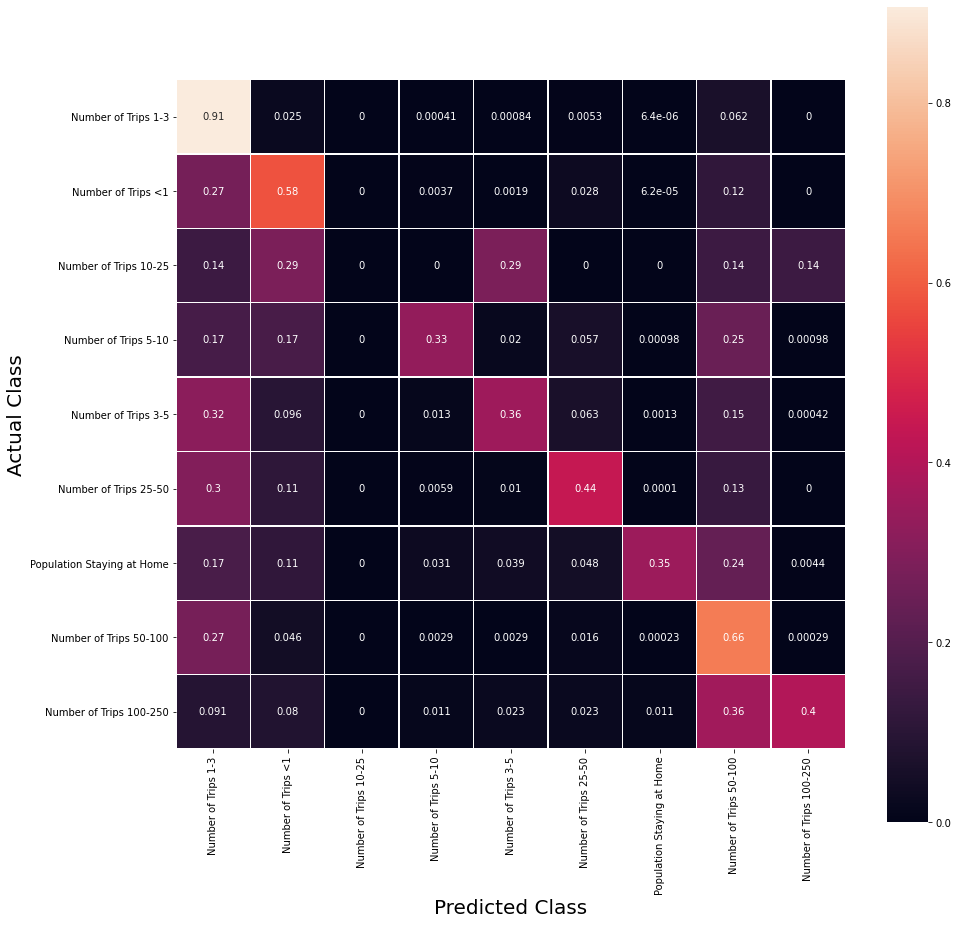

In [39]:
classes = y_test_pre['Max_Trip_Type'].unique()
plot_heatmap(y_test_pre,y_pred_cb_pre,classes, normalize=True)

In [34]:
target_var = 'Max_Trip_Type'
keep_cols = ['weekday','weekend'] + [target_var]
df_mob_train_covid = get_model_df(df_weather, df_mobility,df_covid,df_county,covid=True,df_county_area=df_county_area)

remove_col_list = [col for col in df_mobility.columns if col in df_mob_train_covid and col not in keep_cols]
remove_col_list_COVID = remove_col_list
remove_col_list_COVID.extend(['Lat','Lng'])
df_mob_post_feat_imp_covid,y_test_covid,y_pred_cb_covid,cb_model_covid = run_model_class(df_mob_train_covid,'Post', target_var,remove_col_list,task_type='GPU',max_depth = 6)
df_mob_post_feat_imp_covid.sort_values('Post_Covid_Feature_Importance',ascending=False)[:20]

0:	learn: 0.5525932	total: 358ms	remaining: 1m 29s
50:	learn: 0.7231260	total: 17.5s	remaining: 1m 8s
100:	learn: 0.7524357	total: 35.1s	remaining: 51.8s
150:	learn: 0.7632761	total: 52.8s	remaining: 34.6s
200:	learn: 0.7691012	total: 1m 10s	remaining: 17.2s
249:	learn: 0.7733912	total: 1m 27s	remaining: 0us
0.77


,Post_Covid_Feature_Importance
case_rate,5.080371
STATE,2.697345
weekend,2.159986
weekday,1.879794
Travel Time to Work_10 to 14 minutes,1.649265
County_Population_Density_m2,1.474559
sunHour,1.381350
Sex by Age_Male 67 to 69 years,1.339408
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,1.314295
Sex by Age_Female 85 years and over,1.230317


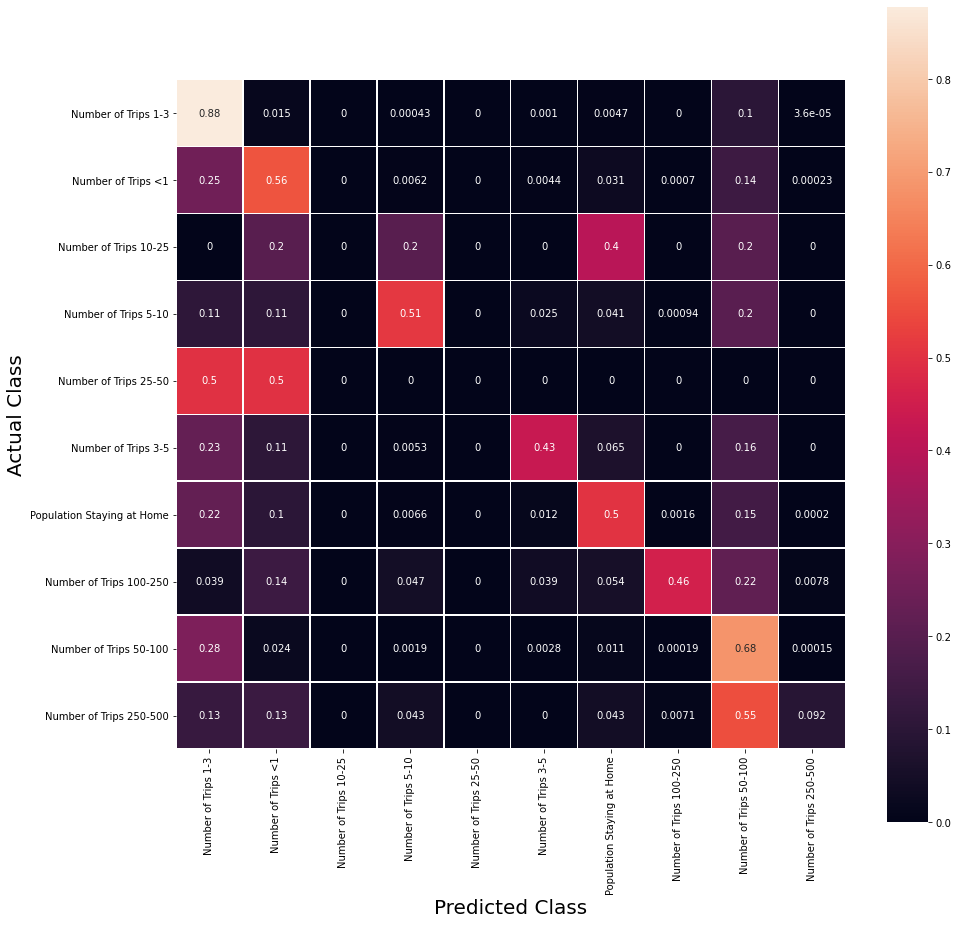

In [40]:
classes = y_test_covid['Max_Trip_Type'].unique()
plot_heatmap(y_test_covid,y_pred_cb_covid,classes, normalize=True)